# EAEE E4000 Final Project

> Project Goal: Predict rainfall in NYC and Boston using predictors: temperature, humidity, sea level pressure, and cloud cover.





In [275]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import activations
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

### **Load Data**

In [276]:
cwd = os.getcwd()
data_path = os.path.join(cwd,"Data.csv")
all_data = pd.read_csv(data_path)
all_data.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"New York City,USA",1/1/14,0.8,-4.4,-1.7,0.8,-10.0,-5.2,-10.9,49.8,...,9.1,5,NaN,2014-01-01T07:20:11,2014-01-01T16:39:19,0.00,Partially cloudy,Becoming cloudy in the afternoon.,partly-cloudy-day,"72505394728,KTEB,KEWR,KLGA,72502014734,KNYC,72..."
1,"New York City,USA",1/2/14,0.6,-7.1,-3.0,-2.9,-15.4,-9.3,-6.8,75.1,...,1.7,1,NaN,2014-01-02T07:20:16,2014-01-02T16:40:10,0.01,"Snow, Overcast",Cloudy skies throughout the day with snow.,rain,"72502594741,72505394728,KTEB,KEWR,KJFK,KLGA,72..."
2,"New York City,USA",1/3/14,-7.8,-12.2,-10.3,-14.8,-21.3,-18.4,-16.3,62.9,...,6.5,4,NaN,2014-01-03T07:20:19,2014-01-03T16:41:03,0.03,"Snow, Partially cloudy",Clearing in the afternoon with snow clearing l...,snow,"72502594741,72505394728,KEWR,KLGA,72502014734,..."
3,"New York City,USA",1/4/14,-2.5,-13.2,-7.7,-5.0,-20.0,-11.0,-16.9,48.6,...,10.0,5,NaN,2014-01-04T07:20:20,2014-01-04T16:41:57,0.07,Clear,Clear conditions throughout the day.,clear-day,"72505394728,KTEB,KEWR,KLGA,72502014734,KNYC,72..."
4,"New York City,USA",1/5/14,3.4,-3.7,-0.6,1.9,-6.4,-2.4,-3.6,80.7,...,3.0,2,NaN,2014-01-05T07:20:19,2014-01-05T16:42:53,0.11,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with rain or ...,rain,"72505394728,KEWR,KLGA,72502014734,KNYC,7250301..."


### **Visualize and Preprocess the Data**

In [277]:
#parse out temp, humidity, cloudcover, sea level pressure, and precipitation
df = all_data[['temp','humidity','cloudcover','sealevelpressure','precip']]
df.head()

,temp,humidity,cloudcover,sealevelpressure,precip
0,-1.7,49.8,45.2,1027.4,0.000
1,-3.0,75.1,100.0,1015.2,5.897
2,-10.3,62.9,53.5,1017.6,7.813
3,-7.7,48.6,16.6,1030.4,0.000
4,-0.6,80.7,75.4,1022.2,3.436


In [278]:
df.isnull().values.any()

False

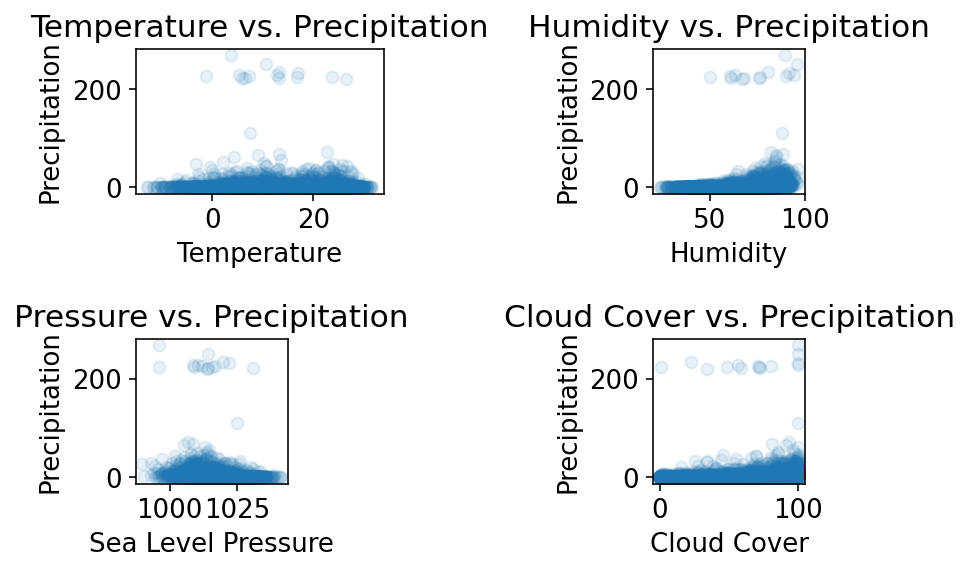

In [279]:
plt.subplot(2, 2, 1)
plt.scatter(df['temp'],df['precip'], alpha=0.1)
plt.xlabel('Temperature')
plt.ylabel('Precipitation')
plt.title('Temperature vs. Precipitation')

plt.subplot(2, 3, 3)
plt.scatter(df['humidity'],df['precip'], alpha=0.1)
plt.xlabel('Humidity')
plt.ylabel('Precipitation')
plt.title('Humidity vs. Precipitation')

plt.subplot(2, 3, 4)
plt.scatter(df['sealevelpressure'],df['precip'], alpha=0.1)
plt.xlabel('Sea Level Pressure')
plt.ylabel('Precipitation')
plt.title('Pressure vs. Precipitation')

plt.subplot(2, 3, 6)
plt.scatter(df['cloudcover'],df['precip'], alpha=0.1)
plt.xlabel('Cloud Cover')
plt.ylabel('Precipitation')
plt.title('Cloud Cover vs. Precipitation')

plt.subplots_adjust(wspace=0.7, hspace=1)
plt.show()

In [280]:
#Normalize all data 
mean = df.mean()
std = df.std()
norm_df = (df-mean)/std
norm_df.head()

,temp,humidity,cloudcover,sealevelpressure,precip
0,-1.635320,-0.879674,-0.008128,1.404671,-0.211203
1,-1.772655,0.866479,1.802850,-0.267672,0.151254
2,-2.543844,0.024461,0.266162,0.061314,0.269021
3,-2.269174,-0.962496,-0.953273,1.815902,-0.211203
4,-1.519113,1.252980,0.989892,0.691869,-0.000010


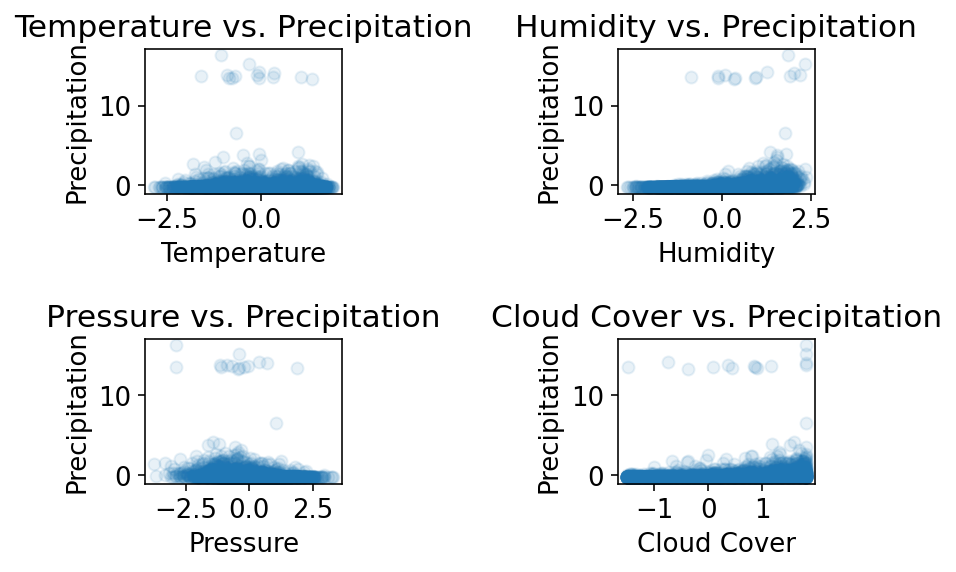

In [281]:
plt.subplot(2, 3, 1)

plt.scatter(norm_df['temp'],norm_df['precip'], alpha=0.1)
plt.xlabel('Temperature')
plt.ylabel('Precipitation')
plt.title('Temperature vs. Precipitation')

plt.subplot(2, 3, 3)
plt.scatter(norm_df['humidity'],norm_df['precip'], alpha=0.1)
plt.xlabel('Humidity')
plt.ylabel('Precipitation')
plt.title('Humidity vs. Precipitation')

plt.subplot(2, 3, 4)
plt.scatter(norm_df['sealevelpressure'],norm_df['precip'], alpha=0.1)
plt.xlabel('Pressure')
plt.ylabel('Precipitation')
plt.title('Pressure vs. Precipitation')

plt.subplot(2, 3, 6)
plt.scatter(norm_df['cloudcover'],norm_df['precip'], alpha=0.1)
plt.xlabel('Cloud Cover')
plt.ylabel('Precipitation')
plt.title('Cloud Cover vs. Precipitation')

plt.subplots_adjust(hspace=1)
plt.show()

In [282]:
index = [i for i in range(len(norm_df))]
norm_df.insert(0, "index", index, True)
norm_df.head()

,index,temp,humidity,cloudcover,sealevelpressure,precip
0,0,-1.635320,-0.879674,-0.008128,1.404671,-0.211203
1,1,-1.772655,0.866479,1.802850,-0.267672,0.151254
2,2,-2.543844,0.024461,0.266162,0.061314,0.269021
3,3,-2.269174,-0.962496,-0.953273,1.815902,-0.211203
4,4,-1.519113,1.252980,0.989892,0.691869,-0.000010


In [283]:
from sklearn.model_selection import train_test_split

#shuffle df
norm_df.sample(frac=1)

#Separate x and y values
x = norm_df[['index','temp','humidity','cloudcover','sealevelpressure']]
y = norm_df['precip']

#df to numpy array
x = x.to_numpy()
y = y.to_numpy()

#split data set
x_train_ind, x_test_ind, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 25)
print("Total: ", x.shape[0], y.shape[0])
print("\nTrain: {}{}, \nTest: {}{}".format(x_train_ind.shape, y_train.shape, x_test_ind.shape, y_test.shape))

Total:  3288 3288

Train: (2466, 5)(2466,), 
Test: (822, 5)(822,)


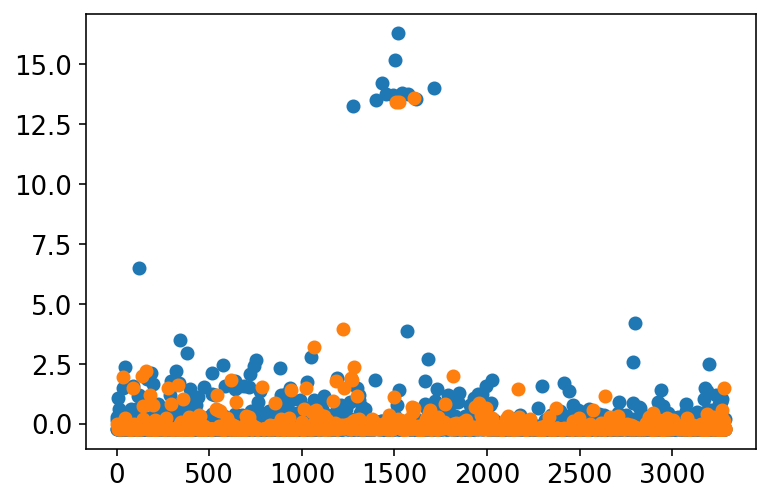

In [284]:
plt.scatter(x_train_ind[:,0], y_train)
plt.scatter(x_test_ind[:,0], y_test)
plt.show()

In [285]:
x_train = x_train_ind[:, 1:]
x_test = x_test_ind[:, 1:]
print("\nTrain: {}{}, \nTest: {}{}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))


Train: (2466, 4)(2466,), 
Test: (822, 4)(822,)


### **Neural Network Model**

In [286]:
#tune hyperparameters
n_neuron       = 64 #32
activation     = 'relu'
num_epochs     = 100
learning_rate  = 1e-5
minibatch_size = 32
model_num      = 1

In [287]:
#define model
model = Sequential()

model.add(Dense(n_neuron,  activation=activation,input_shape=(x_train.shape[1],))) 
model.add(Dense(n_neuron,  activation=activation)) 
model.add(Dense(n_neuron,  activation=activation)) 
model.add(Dense(1,  activation='linear')) 

model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [289]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 64)                320       
                                                                 
 dense_33 (Dense)            (None, 64)                4160      
                                                                 
 dense_34 (Dense)            (None, 64)                4160      
                                                                 
 dense_35 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8,705
Trainable params: 8,705
Non-trainable params: 0
_________________________________________________________________


In [290]:
#use EarlyStopping as in example to avoid over-fitting
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

history = model.fit(x_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.33, 
                    verbose         = 1,
                    callbacks       = [early_stop])

Epoch 1/100
52/52 [==============================] - 1s 7ms/step - loss: 1.3619 - val_loss: 0.3688
Epoch 2/100
52/52 [==============================] - 0s 4ms/step - loss: 1.3570 - val_loss: 0.3655
Epoch 3/100
52/52 [==============================] - 0s 3ms/step - loss: 1.3522 - val_loss: 0.3626
Epoch 4/100
52/52 [==============================] - 0s 4ms/step - loss: 1.3477 - val_loss: 0.3600
Epoch 5/100
52/52 [==============================] - 0s 4ms/step - loss: 1.3433 - val_loss: 0.3578
Epoch 6/100
52/52 [==============================] - 0s 4ms/step - loss: 1.3393 - val_loss: 0.3558
Epoch 7/100
52/52 [==============================] - 0s 4ms/step - loss: 1.3353 - val_loss: 0.3539
Epoch 8/100
52/52 [==============================] - 0s 4ms/step - loss: 1.3317 - val_loss: 0.3518
Epoch 9/100
52/52 [==============================] - 0s 4ms/step - loss: 1.3282 - val_loss: 0.3503
Epoch 10/100
52/52 [==============================] - 0s 4ms/step - loss: 1.3249 - val_loss: 0.3492
Epoch 11/

### **Evaluating the Trained NN Model**

In [291]:
y_test_pre = model.predict(x_test)

26/26 [==============================] - 0s 2ms/step


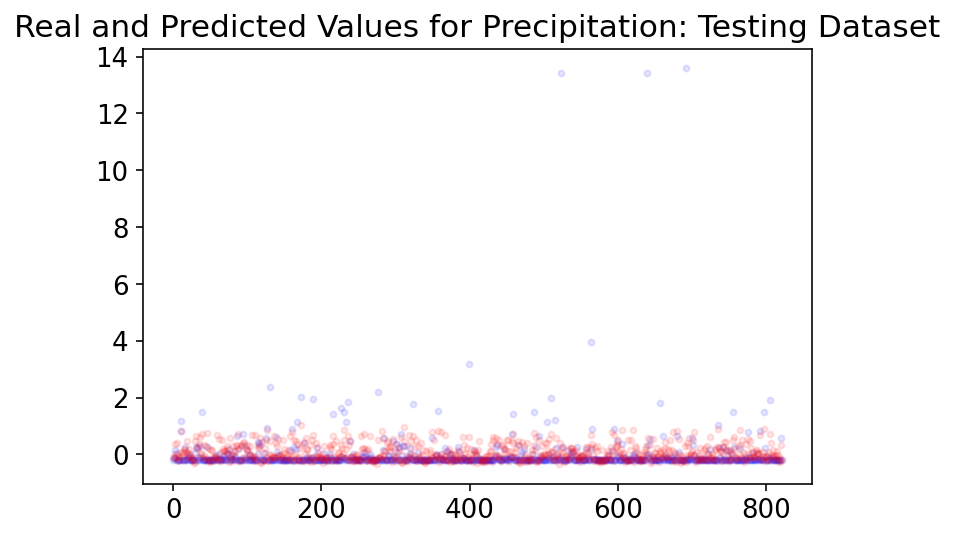

In [292]:
fig = plt.figure()
plt.plot(y_test, 'b', linestyle="",marker=".", alpha=0.1) 
plt.plot(y_test_pre, 'r', linestyle="",marker=".", alpha=0.1)
plt.title("Real and Predicted Values for Precipitation: Testing Dataset")
plt.show()

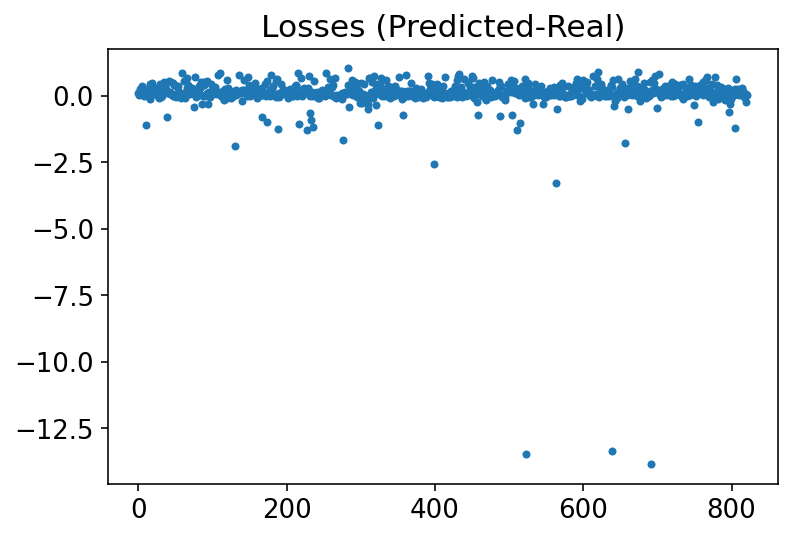

In [293]:
losses = [y_test_pre[i][0] - y_test[i] for i in range(len(y_test))]
plt.title("Losses (Predicted-Real)")
plt.plot(losses, linestyle="",marker=".")

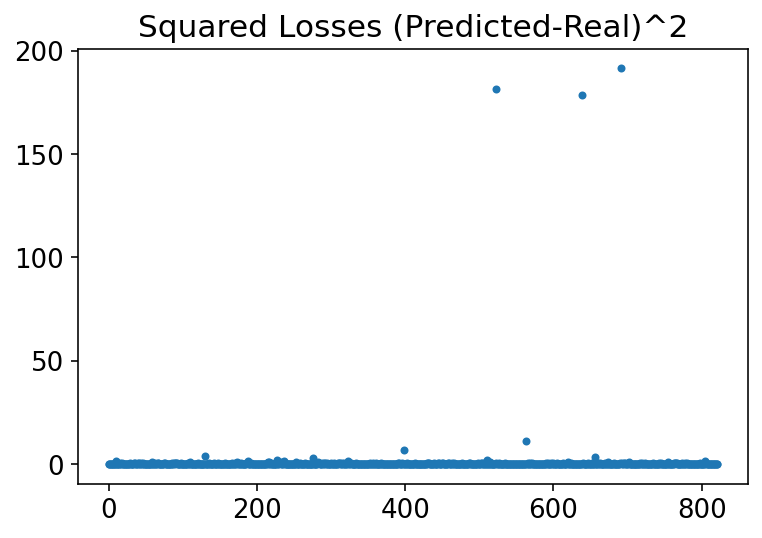

In [294]:
from math import sqrt
losses_sqrd = [losses[i]*losses[i] for i in range(len(losses))]
plt.title("Squared Losses (Predicted-Real)^2")
plt.plot(losses_sqrd, linestyle="",marker=".")

In [295]:
avg_sqrd_residual = sum(losses_sqrd) / len(losses_sqrd)
rmse_NN = sqrt(avg_sqrd_residual)
print("RMSE for NN Model: {}".format(rmse_NN))

RMSE for NN Model: 0.8955744182948987


### **Transfer Learning using the NN Model**


> Use pretrained model with data across 2014-2022 for 10027 (NYC zip code) for data across 2022 for 02138 (Massachusetts zip code)



### **Load the Transfer Learning Data**

In [296]:
cwd = os.getcwd()
tdata_path = os.path.join(cwd,"TransferData.csv")
all_tdata = pd.read_csv(tdata_path)
all_tdata.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,2138,2022-01-01,51.4,44.4,47.2,51.4,42.2,46.4,46.5,97.5,...,0.4,0,NaN,2022-01-01T07:13:57,2022-01-01T16:22:35,0.99,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"F2140,KOWD,72509854704,KBED,KBOS,72509014739,7..."
1,2138,2022-01-02,46.3,33.6,43.1,46.3,25.4,38.8,40.3,90.1,...,0.5,0,NaN,2022-01-02T07:14:01,2022-01-02T16:23:28,1.00,"Rain, Overcast",Cloudy skies throughout the day with a chance ...,rain,"F2140,KOWD,72509854704,KBED,KBOS,72509014739,7..."
2,2138,2022-01-03,32.8,22.6,26.8,23.8,9.9,16.0,11.9,52.9,...,0.6,0,NaN,2022-01-03T07:14:02,2022-01-03T16:24:23,0.00,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"F2140,KOWD,72509854704,KBED,KBOS,72509014739,7..."
3,2138,2022-01-04,31.3,16.5,23.7,25.8,3.8,14.5,4.7,44.1,...,2.5,3,NaN,2022-01-04T07:14:01,2022-01-04T16:25:19,0.02,Clear,Clear conditions throughout the day.,clear-day,"F2140,KOWD,AV085,72509854704,KBED,KBOS,7250901..."
4,2138,2022-01-05,50.6,24.4,39.7,50.6,17.4,34.5,35.4,84.6,...,0.7,1,NaN,2022-01-05T07:13:57,2022-01-05T16:26:17,0.05,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"F2140,KOWD,72509854704,KBED,KBOS,72509014739,7..."


### **Visualize and Preprocess the New Data**

In [297]:
#parse out temp, humidity, cloudcover, sea level pressure, and precipitation
tdf = all_tdata[['temp','humidity','cloudcover','sealevelpressure','precip']]
tdf.head()

,temp,humidity,cloudcover,sealevelpressure,precip
0,47.2,97.5,100.0,1009.9,0.053
1,43.1,90.1,92.8,1004.0,0.232
2,26.8,52.9,76.9,1019.6,0.000
3,23.7,44.1,19.6,1026.5,0.000
4,39.7,84.6,79.1,1014.3,0.137


In [298]:
tdf.isnull().values.any()

False

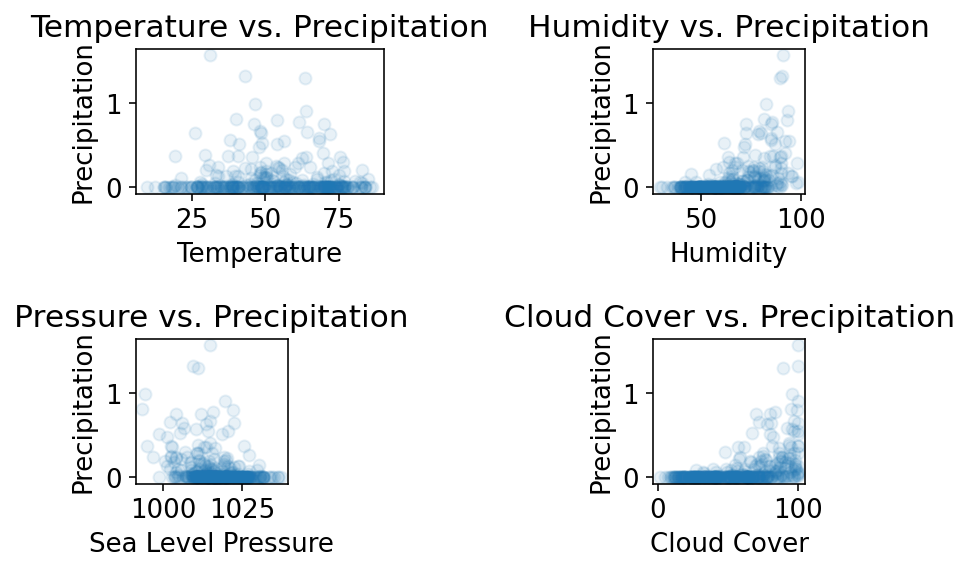

In [299]:
plt.subplot(2, 2, 1)
plt.scatter(tdf['temp'],tdf['precip'], alpha=0.1)
plt.xlabel('Temperature')
plt.ylabel('Precipitation')
plt.title('Temperature vs. Precipitation')

plt.subplot(2, 3, 3)
plt.scatter(tdf['humidity'],tdf['precip'], alpha=0.1)
plt.xlabel('Humidity')
plt.ylabel('Precipitation')
plt.title('Humidity vs. Precipitation')

plt.subplot(2, 3, 4)
plt.scatter(tdf['sealevelpressure'],tdf['precip'], alpha=0.1)
plt.xlabel('Sea Level Pressure')
plt.ylabel('Precipitation')
plt.title('Pressure vs. Precipitation')

plt.subplot(2, 3, 6)
plt.scatter(tdf['cloudcover'],tdf['precip'], alpha=0.1)
plt.xlabel('Cloud Cover')
plt.ylabel('Precipitation')
plt.title('Cloud Cover vs. Precipitation')

plt.subplots_adjust(wspace=0.7, hspace=1)
plt.show()

In [300]:
#Normalize all data 
tmean = tdf.mean()
tstd = tdf.std()
norm_tdf = (tdf-tmean)/tstd
norm_tdf.head()

,temp,humidity,cloudcover,sealevelpressure,precip
0,-0.345815,2.231925,1.664109,-0.888085,-0.160525
1,-0.580909,1.732676,1.388234,-1.641894,0.704958
2,-1.515552,-0.777061,0.779010,0.351229,-0.416786
3,-1.693306,-1.370763,-1.416493,1.232803,-0.416786
4,-0.775866,1.361613,0.863305,-0.325922,0.245623


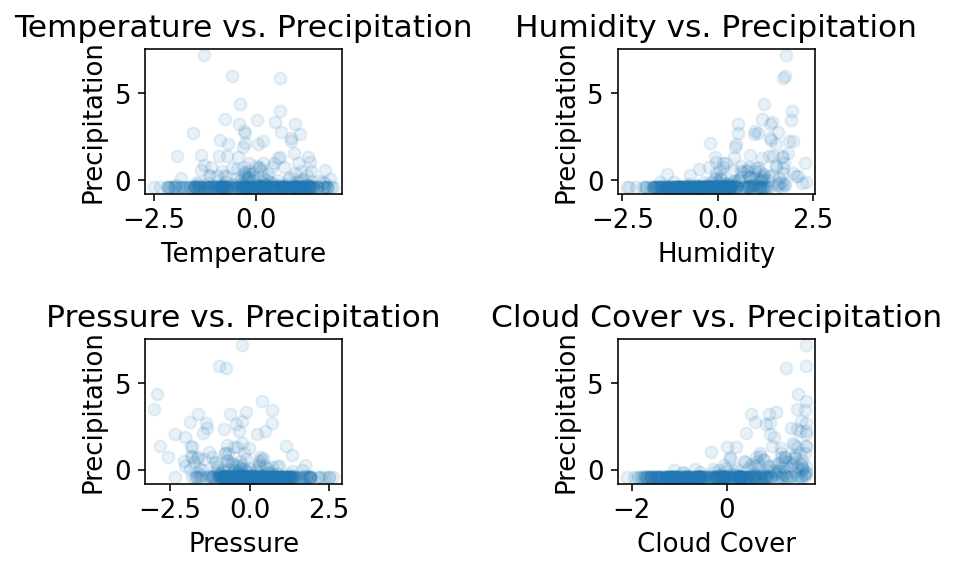

In [301]:
plt.subplot(2, 3, 1)

plt.scatter(norm_tdf['temp'],norm_tdf['precip'], alpha=0.1)
plt.xlabel('Temperature')
plt.ylabel('Precipitation')
plt.title('Temperature vs. Precipitation')

plt.subplot(2, 3, 3)
plt.scatter(norm_tdf['humidity'],norm_tdf['precip'], alpha=0.1)
plt.xlabel('Humidity')
plt.ylabel('Precipitation')
plt.title('Humidity vs. Precipitation')

plt.subplot(2, 3, 4)
plt.scatter(norm_tdf['sealevelpressure'],norm_tdf['precip'], alpha=0.1)
plt.xlabel('Pressure')
plt.ylabel('Precipitation')
plt.title('Pressure vs. Precipitation')

plt.subplot(2, 3, 6)
plt.scatter(norm_tdf['cloudcover'],norm_tdf['precip'], alpha=0.1)
plt.xlabel('Cloud Cover')
plt.ylabel('Precipitation')
plt.title('Cloud Cover vs. Precipitation')

plt.subplots_adjust(hspace=1)
plt.show()

In [302]:
index_t = [i for i in range(len(norm_tdf))]
norm_tdf.insert(0, "index", index_t, True)
norm_tdf.head()

,index,temp,humidity,cloudcover,sealevelpressure,precip
0,0,-0.345815,2.231925,1.664109,-0.888085,-0.160525
1,1,-0.580909,1.732676,1.388234,-1.641894,0.704958
2,2,-1.515552,-0.777061,0.779010,0.351229,-0.416786
3,3,-1.693306,-1.370763,-1.416493,1.232803,-0.416786
4,4,-0.775866,1.361613,0.863305,-0.325922,0.245623


In [303]:
#shuffle df
norm_tdf.sample(frac=1)

#Separate x and y values
x_t = norm_tdf[['index','temp','humidity','cloudcover','sealevelpressure']]
y_t = norm_tdf['precip']

#df to numpy array
x_t = x_t.to_numpy()
y_t = y_t.to_numpy()

#split data set
xt_train_ind, xt_test_ind, yt_train, yt_test = train_test_split(x_t, y_t, test_size = 0.25, random_state = 25)
print("Total: ", x_t.shape[0], y_t.shape[0])
print("\nTrain: {}{}, \nTest: {}{}".format(xt_train_ind.shape, yt_train.shape, xt_test_ind.shape, yt_test.shape))

Total:  365 365

Train: (273, 5)(273,), 
Test: (92, 5)(92,)


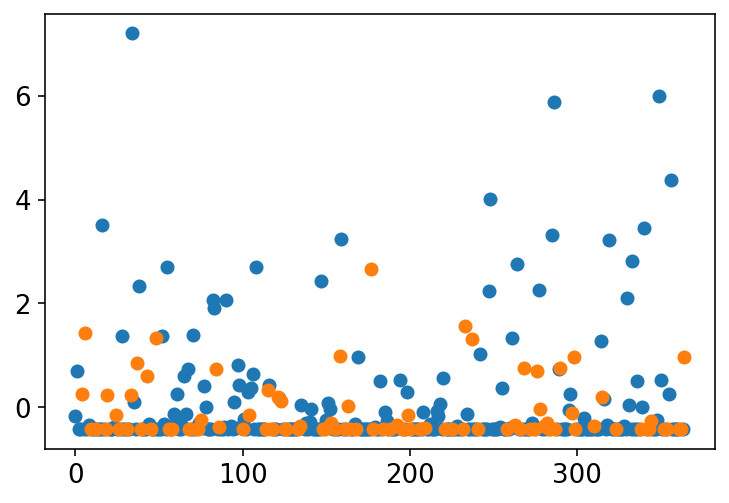

In [304]:
plt.scatter(xt_train_ind[:,0], yt_train)
plt.scatter(xt_test_ind[:,0], yt_test)
plt.show()

In [305]:
xt_train = xt_train_ind[:, 1:]
xt_test = xt_test_ind[:, 1:]
print("\nTrain: {}{}, \nTest: {}{}".format(xt_train.shape, yt_train.shape, xt_test.shape, yt_test.shape))


Train: (273, 4)(273,), 
Test: (92, 4)(92,)


### **Train on Non-Pre-Trained NN Model**

In [306]:
#define model
model_npt = Sequential()

model_npt.add(Dense(n_neuron,  activation=activation,input_shape=(xt_train.shape[1],))) 
model_npt.add(Dense(n_neuron,  activation=activation)) 
model_npt.add(Dense(n_neuron,  activation=activation)) 
model_npt.add(Dense(1,  activation='linear')) 

model_npt.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [307]:
model_npt.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 64)                320       
                                                                 
 dense_37 (Dense)            (None, 64)                4160      
                                                                 
 dense_38 (Dense)            (None, 64)                4160      
                                                                 
 dense_39 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8,705
Trainable params: 8,705
Non-trainable params: 0
_________________________________________________________________


In [308]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)
history_npt = model_npt.fit(xt_train, yt_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.33, 
                    verbose         = 1,
                    callbacks       = [early_stop])

Epoch 1/100
6/6 [==============================] - 1s 144ms/step - loss: 1.7492 - val_loss: 0.5733
Epoch 2/100
6/6 [==============================] - 0s 13ms/step - loss: 1.7440 - val_loss: 0.5702
Epoch 3/100
6/6 [==============================] - 0s 11ms/step - loss: 1.7388 - val_loss: 0.5672
Epoch 4/100
6/6 [==============================] - 0s 13ms/step - loss: 1.7336 - val_loss: 0.5643
Epoch 5/100
6/6 [==============================] - 0s 13ms/step - loss: 1.7284 - val_loss: 0.5613
Epoch 6/100
6/6 [==============================] - 0s 14ms/step - loss: 1.7236 - val_loss: 0.5584
Epoch 7/100
6/6 [==============================] - 0s 10ms/step - loss: 1.7187 - val_loss: 0.5556
Epoch 8/100
6/6 [==============================] - 0s 12ms/step - loss: 1.7135 - val_loss: 0.5527
Epoch 9/100
6/6 [==============================] - 0s 9ms/step - loss: 1.7087 - val_loss: 0.5500
Epoch 10/100
6/6 [==============================] - 0s 9ms/step - loss: 1.7038 - val_loss: 0.5471
Epoch 11/100
6/6 [==

### **Evaluating the Non-Pre-Trained NN Model**

In [309]:
ynpt_test_pre = model_npt.predict(xt_test)

3/3 [==============================] - 0s 4ms/step


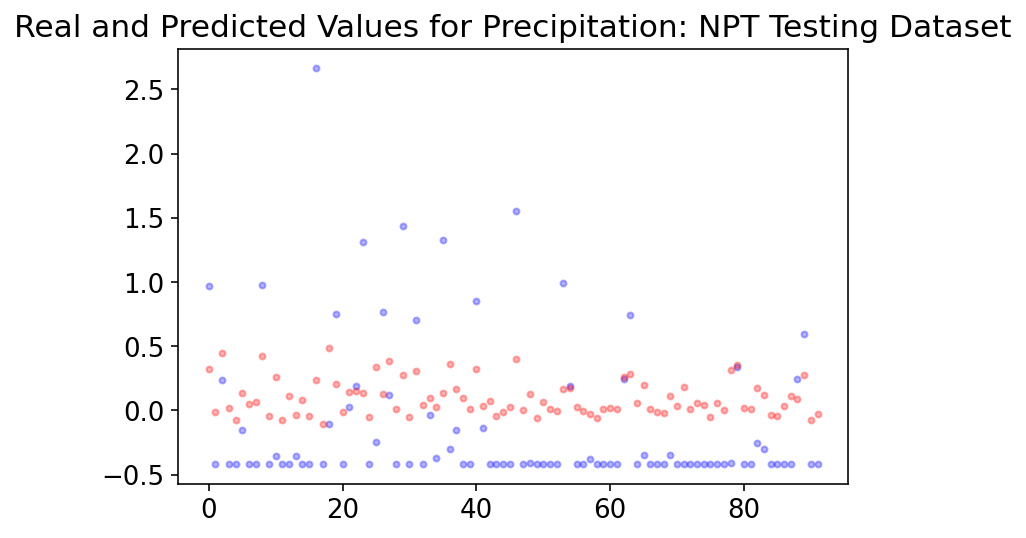

In [310]:
fig = plt.figure()
plt.plot(yt_test, 'b', linestyle="",marker=".", alpha=0.3)
plt.plot(ynpt_test_pre, 'r', linestyle="",marker=".", alpha=0.3)
plt.title("Real and Predicted Values for Precipitation: NPT Testing Dataset")
plt.show()

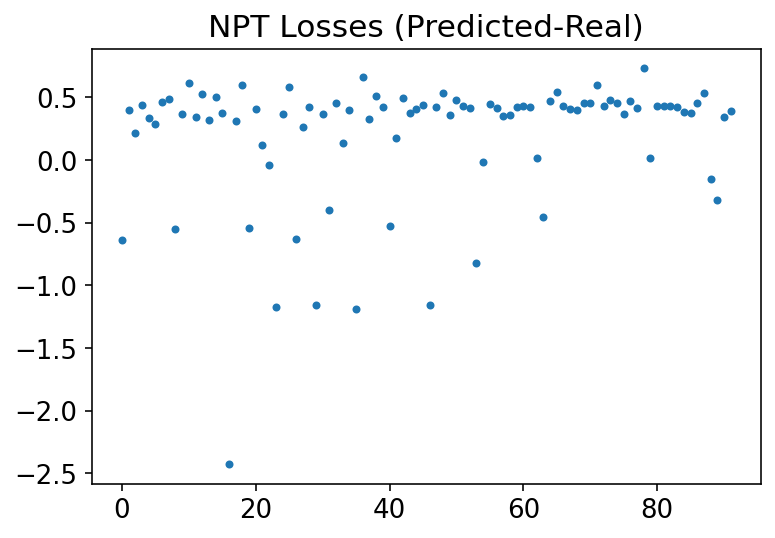

In [311]:
losses_npt = [ynpt_test_pre[i][0] - yt_test[i] for i in range(len(yt_test))]
plt.title("NPT Losses (Predicted-Real)")
plt.plot(losses_npt, linestyle="",marker=".")

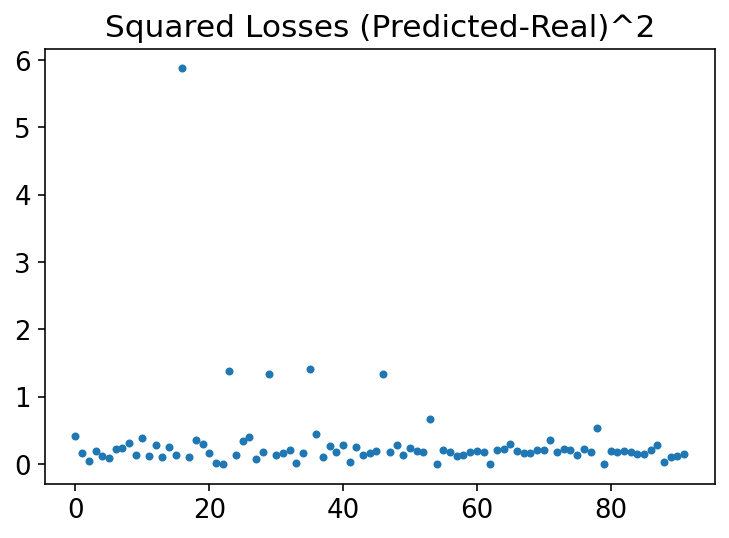

In [312]:
from math import sqrt
losses_npt_sqrd = [losses_npt[i]*losses_npt[i] for i in range(len(losses_npt))]
plt.title("Squared Losses (Predicted-Real)^2")
plt.plot(losses_npt_sqrd, linestyle="",marker=".")

In [313]:
avg_sqrd_residual_npt = sum(losses_npt_sqrd) / len(losses_npt_sqrd)
rmse_NN_npt = sqrt(avg_sqrd_residual_npt)
print("RMSE for Not Pre-Trained NN Model: {}".format(rmse_NN_npt))

RMSE for Not Pre-Trained NN Model: 0.5505375958371785


### **Train on Pre-Trained NN Model**

In [314]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

model_pretrain = model
model_pretrain.get_layer("dense_32").trainable = False
model_pretrain.get_layer("dense_33").trainable = False
model_pretrain.get_layer("dense_34").trainable = True
model_pretrain.get_layer("dense_35").trainable = True
    
    
history_pretrain = model_pretrain.fit(xt_train, yt_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.33, 
                    verbose         = 1,
                    callbacks       = [early_stop])

Epoch 1/100
6/6 [==============================] - 0s 19ms/step - loss: 1.2069 - val_loss: 0.3182
Epoch 2/100
6/6 [==============================] - 0s 10ms/step - loss: 1.2049 - val_loss: 0.3179
Epoch 3/100
6/6 [==============================] - 0s 11ms/step - loss: 1.2023 - val_loss: 0.3175
Epoch 4/100
6/6 [==============================] - 0s 9ms/step - loss: 1.1983 - val_loss: 0.3171
Epoch 5/100
6/6 [==============================] - 0s 11ms/step - loss: 1.1941 - val_loss: 0.3167
Epoch 6/100
6/6 [==============================] - 0s 12ms/step - loss: 1.1916 - val_loss: 0.3163
Epoch 7/100
6/6 [==============================] - 0s 11ms/step - loss: 1.1873 - val_loss: 0.3158
Epoch 8/100
6/6 [==============================] - 0s 10ms/step - loss: 1.1838 - val_loss: 0.3154
Epoch 9/100
6/6 [==============================] - 0s 11ms/step - loss: 1.1801 - val_loss: 0.3150
Epoch 10/100
6/6 [==============================] - 0s 9ms/step - loss: 1.1765 - val_loss: 0.3146
Epoch 11/100
6/6 [===

### **Evaluating the Transfer Learning Model**

In [315]:
y_test_pret = model_pretrain.predict(xt_test)

3/3 [==============================] - 0s 3ms/step


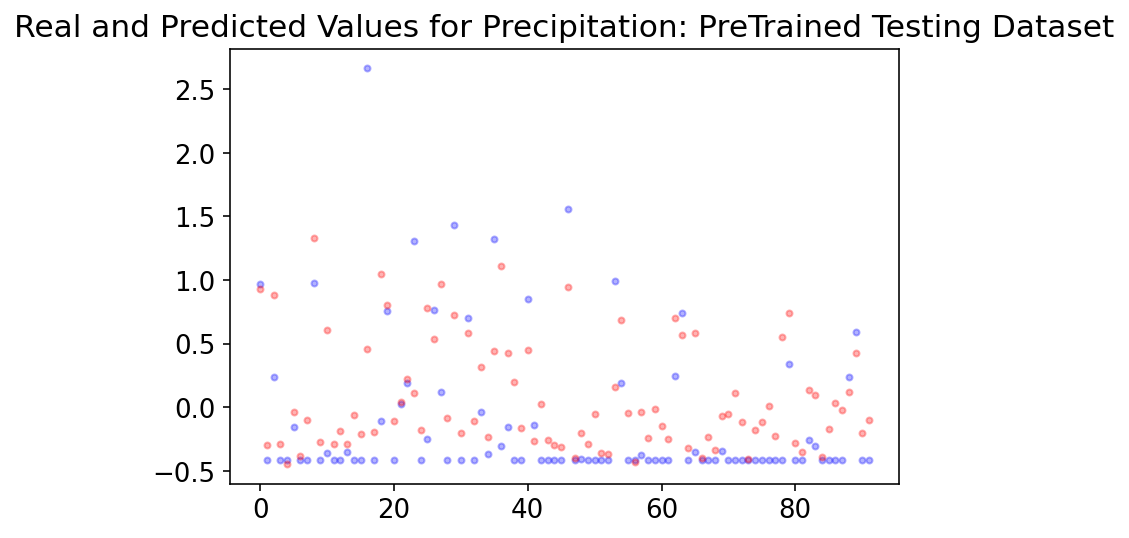

In [316]:
fig = plt.figure()
plt.plot(yt_test, 'b', linestyle="",marker=".", alpha=0.3)
plt.plot(y_test_pret, 'r', linestyle="",marker=".", alpha=0.3)
plt.title("Real and Predicted Values for Precipitation: PreTrained Testing Dataset")
plt.show()

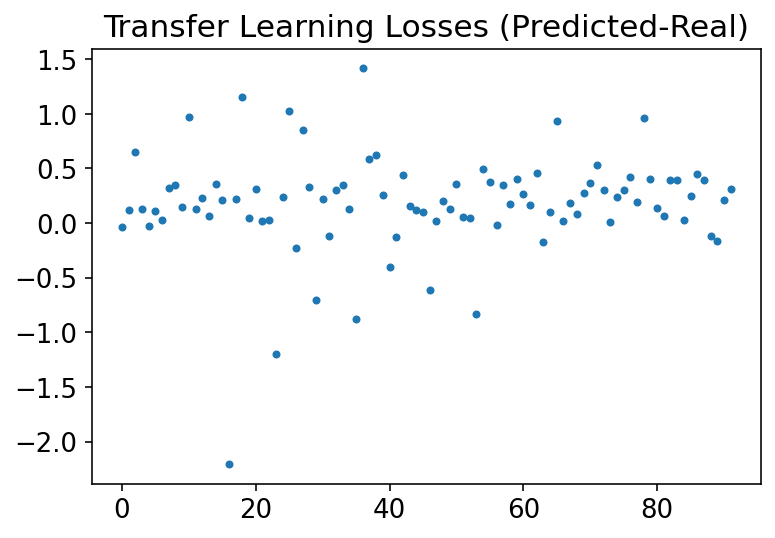

In [317]:
losses_pret = [y_test_pret[i][0] - yt_test[i] for i in range(len(yt_test))]
plt.title("Transfer Learning Losses (Predicted-Real)")
plt.plot(losses_pret, linestyle="",marker=".")

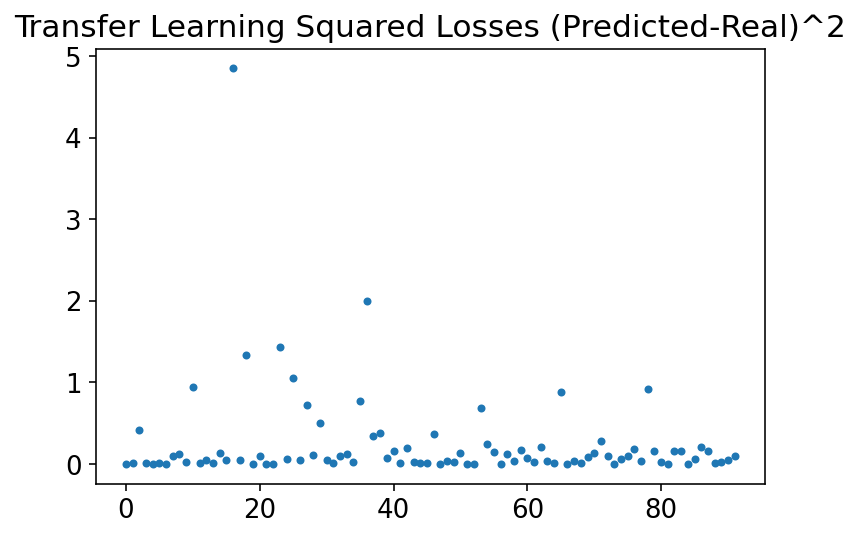

In [318]:
from math import sqrt
losses_sqrd_t = [losses_pret[i]*losses_pret[i] for i in range(len(losses_pret))]
plt.title("Transfer Learning Squared Losses (Predicted-Real)^2")
plt.plot(losses_sqrd_t, linestyle="",marker=".")

In [319]:
avg_sqrd_residual_t = sum(losses_sqrd_t) / len(losses_sqrd_t)
rmse_tl = sqrt(avg_sqrd_residual_t)
print("RMSE for Not Pre-Trained NN Model: {}".format(rmse_NN_npt))
print("RMSE for Transfer Learning Model: {}".format(rmse_tl))

RMSE for Not Pre-Trained NN Model: 0.5505375958371785
RMSE for Transfer Learning Model: 0.4960217220547682


### **Extreme Gradient Boosting**

In [320]:
from xgboost import XGBRegressor
from xgboost import plot_importance

In [321]:
#set hyperparameters to tune
params_xgb = {'objective': 'reg:squarederror',
              'n_estimators': 200,
              'learning_rate': 6e-3, 
              'max_depth': 1}

In [322]:
#define model
model_xgb = XGBRegressor(**params_xgb)

In [323]:
#train model
model_xgb.fit(x_train, y_train)

XGBRegressor(learning_rate=0.006, max_depth=1, n_estimators=200,
             objective='reg:squarederror')

### **Evaluating the Trained XGB Model**

In [324]:
#predict from model
y_pre_xgb = model_xgb.predict(x_test)

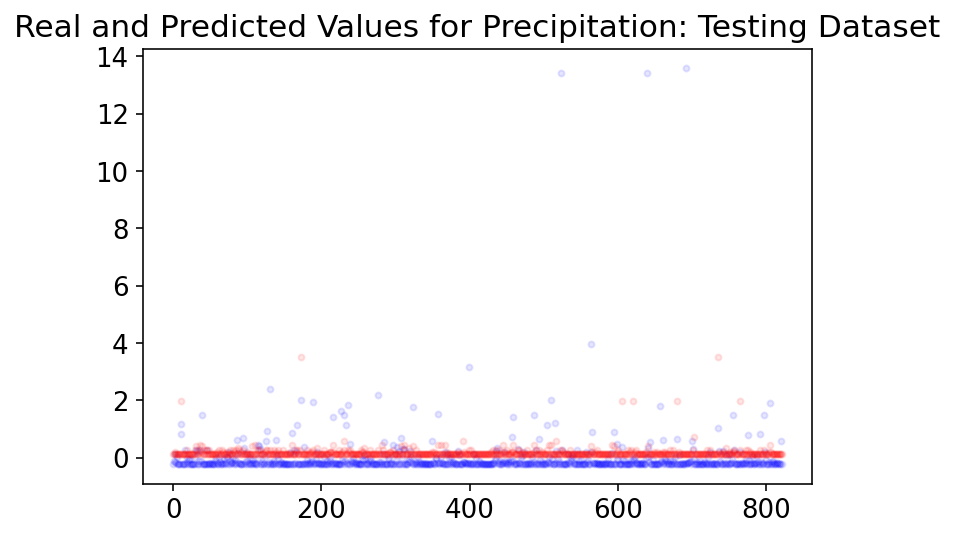

In [325]:
fig = plt.figure()
plt.plot(y_test, 'b', linestyle="",marker=".", alpha=0.1)
plt.plot(y_pre_xgb, 'r', linestyle="",marker=".", alpha=0.1)
plt.title("Real and Predicted Values for Precipitation: Testing Dataset")
plt.show()

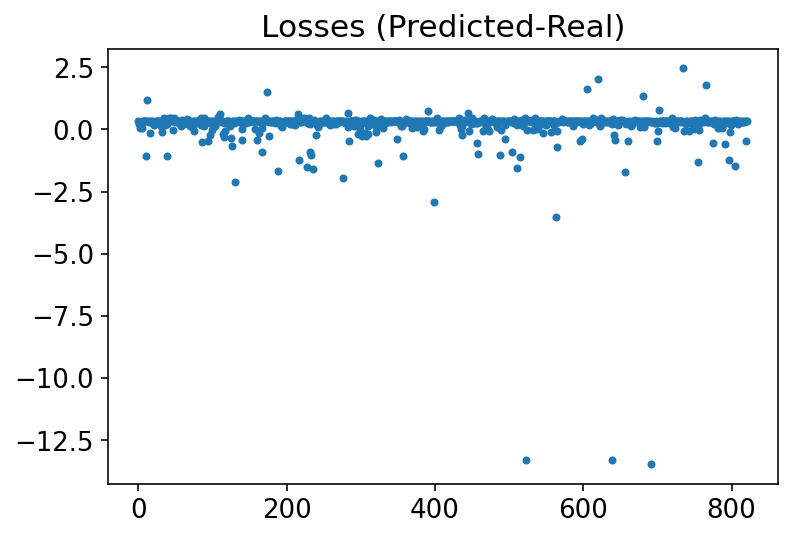

In [326]:
losses_xgb = [y_pre_xgb[i] - y_test[i] for i in range(len(y_test))]
plt.title("Losses (Predicted-Real)")
plt.plot(losses_xgb, linestyle="",marker=".")

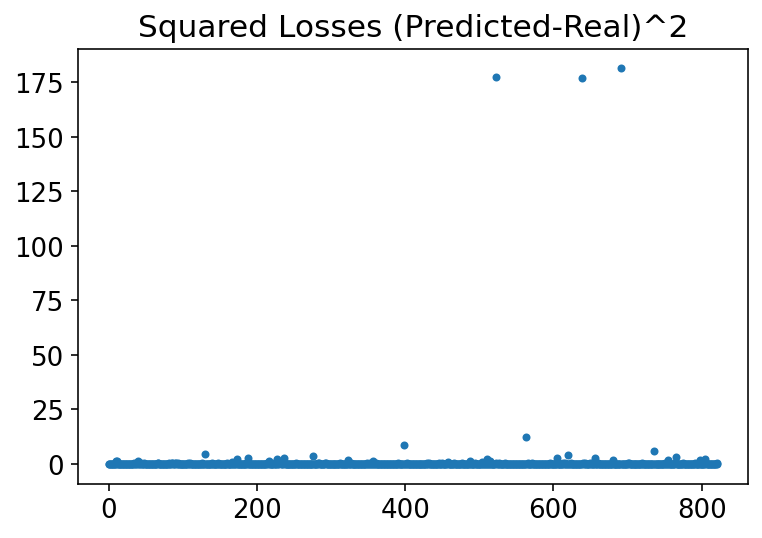

In [327]:
from math import sqrt
losses_sqrd_xgb = [losses_xgb[i]*losses_xgb[i] for i in range(len(losses_xgb))]
plt.title("Squared Losses (Predicted-Real)^2")
plt.plot(losses_sqrd_xgb, linestyle="",marker=".")

In [328]:
avg_sqrd_residual_xgb = sum(losses_sqrd_xgb) / len(losses_sqrd_xgb)
rmse_xgb = sqrt(avg_sqrd_residual_xgb)
print("RMSE for XGB Model: {}".format(rmse_xgb))

RMSE for XGB Model: 0.9206860182860264


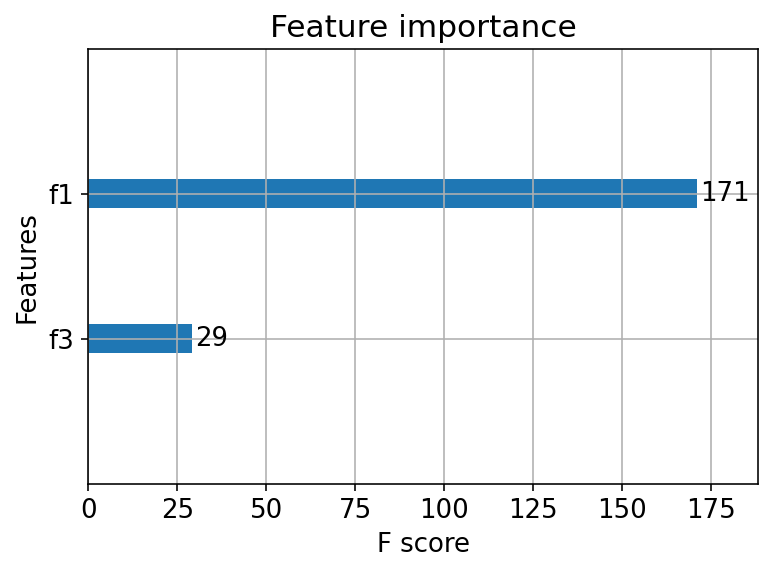

Index(['temp', 'humidity', 'cloudcover', 'sealevelpressure', 'precip'], dtype='object')

In [329]:
plot_importance(model_xgb)
plt.show()
df.columns 

### **Conclusion**

In [330]:
print("RMSE for NN Model for NYC Data: {}".format(rmse_NN))
print("RMSE for Not Pre-Trained NN Model for Boston Data: {}".format(rmse_NN_npt))
print("RMSE for Transfer Learning Model for Boston Data: {}".format(rmse_tl))
print("RMSE for XGB Model for NYC Data: {}".format(rmse_xgb))

RMSE for NN Model for NYC Data: 0.8955744182948987
RMSE for Not Pre-Trained NN Model for Boston Data: 0.5505375958371785
RMSE for Transfer Learning Model for Boston Data: 0.4960217220547682
RMSE for XGB Model for NYC Data: 0.9206860182860264
